In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot style customization for better looking
from matplotlib import rc
from IPython.display import set_matplotlib_formats

plt.style.use("seaborn-deep")
set_matplotlib_formats('retina')

rc('figure', figsize=(9, 9))
rc('axes', labelsize=16, titlesize=16, edgecolor='black')
rc('xtick', labelsize=13)
rc('ytick', labelsize=13)
rc('patch', force_edgecolor=True)
rc('font', weight='regular', size=14)
#

# Data preprocessing and research

In [2]:
user_good_history = pd.read_csv(
    'data/interactions.csv',
    names=['user_id', 'good_id', 'interaction_value'],
    skiprows=1
)

user_good_history

,user_id,good_id,interaction_value
0,0,3568,1.0
1,0,3827,1.0
2,0,4844,1.0
3,0,5734,1.0
4,0,6518,1.0
...,...,...,...
398631,30910,18176,1.0
398632,30910,18185,1.0
398633,30910,18248,1.0
398634,30910,18349,1.0


In [3]:
user_good_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398636 entries, 0 to 398635
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            398636 non-null  int64  
 1   good_id            398636 non-null  int64  
 2   interaction_value  398636 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 9.1 MB


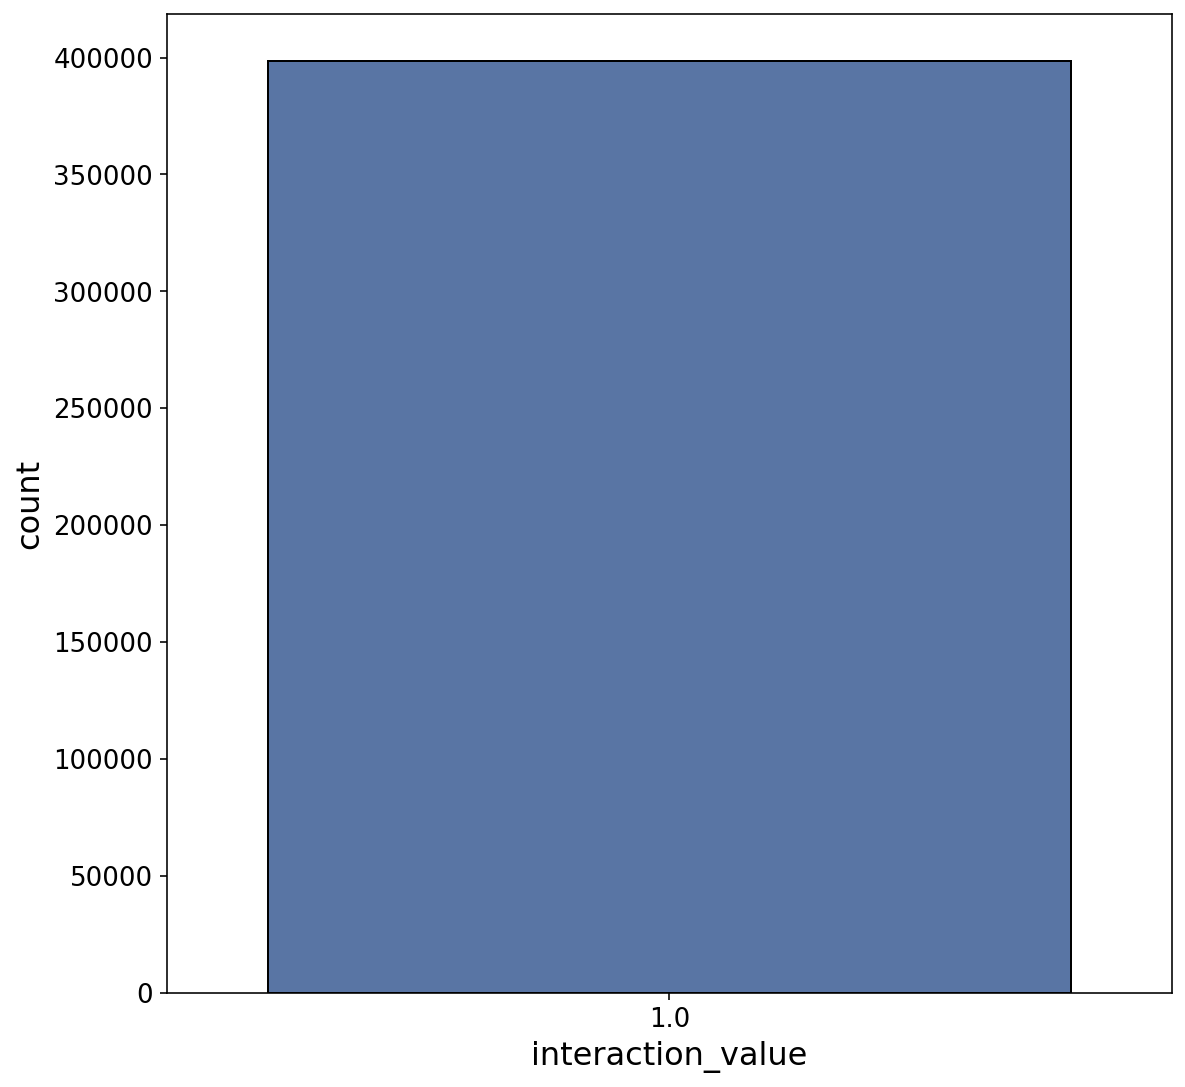

In [4]:
sns.countplot(user_good_history.interaction_value)

The user-good interactions dataset contains only positive examples hence we deal with implicit feedback type. Both users and goods are encoded as some int numbers so we can use them directly in interaction matrix construction.

## Goods datasets

In [5]:
goods_assets = pd.read_csv(
    'data/item_asset.csv',
    names=['good_id', 'feature_id', 'feature_value'],
    skiprows=1
)

goods_assets

,good_id,feature_id,feature_value
0,0,0,0.009497
1,1,0,0.004226
2,2,0,0.003371
3,3,0,0.002991
4,4,0,0.002991
...,...,...,...
18485,18490,0,0.006268
18486,18491,0,0.012536
18487,18492,0,0.006268
18488,18493,0,0.005698


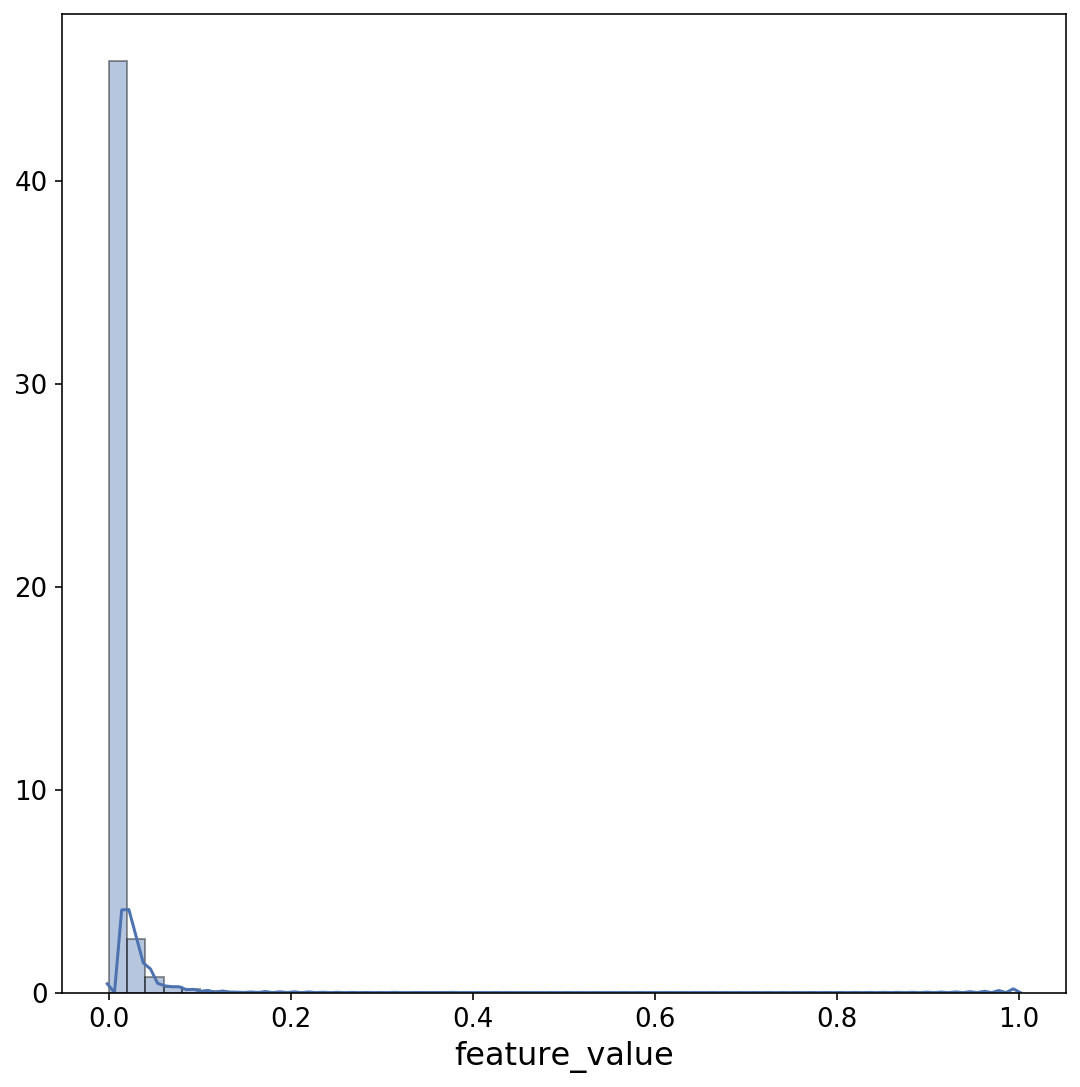

In [6]:
sns.distplot(goods_assets.feature_value)

In [7]:
if goods_assets[goods_assets.feature_id != 0].empty:
    goods_assets.drop('feature_id', axis=1, inplace=True)
else:
    print('Some goods have more than one feature defined')

We have only one feature for each of goods as the problem description states

In [8]:
goods_prices = pd.read_csv(
    'data/item_price.csv', names=['good_id', 'record_id', 'price'], skiprows=1
).drop('record_id', axis=1)

goods_prices

,good_id,price
0,0,0.012911
1,1,0.005211
2,2,0.004131
3,3,0.003521
4,4,0.003521
...,...,...
18488,18490,0.008216
18489,18491,0.016620
18490,18492,0.008216
18491,18493,0.007418


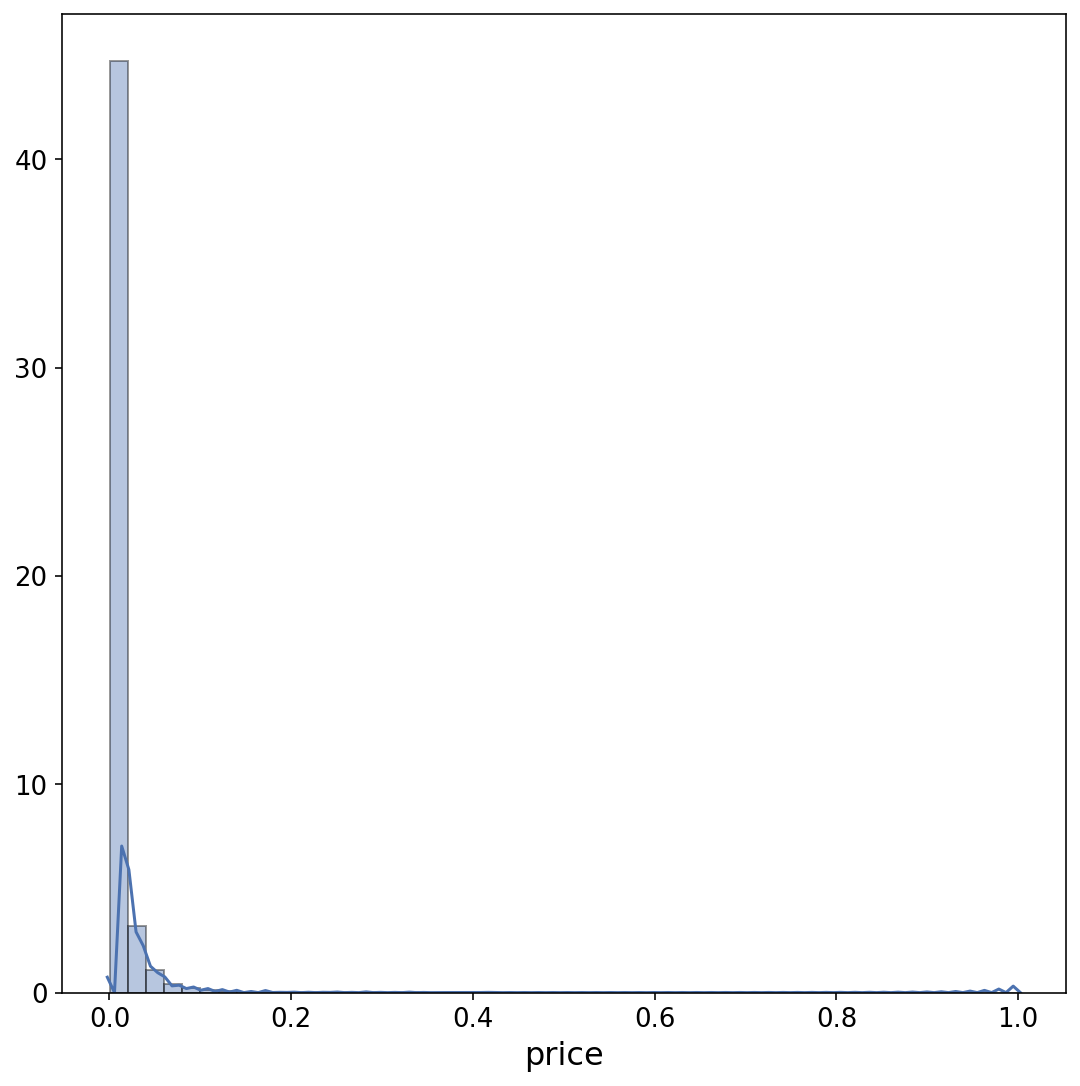

In [9]:
sns.distplot(goods_prices.price)

In [10]:
goods_subclasses = pd.read_csv(
    'data/item_subclass.csv',
    names=['good_id', 'category_id', 'belongs'],
    skiprows=1
)

goods_subclasses

,good_id,category_id,belongs
0,0,679,1.0
1,1,1376,1.0
2,2,1495,1.0
3,3,502,1.0
4,4,502,1.0
...,...,...,...
18490,18490,1207,1.0
18491,18491,1207,1.0
18492,18492,1207,1.0
18493,18493,1207,1.0


In [11]:
goods_subclasses.describe()

,good_id,category_id,belongs
count,18495.00000,18495.000000,18495.0
mean,9247.00000,1013.417626,1.0
std,5339.19095,584.487728,0.0
min,0.00000,1.000000,1.0
25%,4623.50000,502.000000,1.0
50%,9247.00000,1025.000000,1.0
75%,13870.50000,1544.000000,1.0
max,18494.00000,2010.000000,1.0


In [12]:
if goods_subclasses.belongs.std():
    raise RuntimeError('Certainly there are errors in subclasses data collection')
else:
    goods_subclasses.drop('belongs', axis=1, inplace=True)

print('Most wide categories are: ')
goods_subclasses.category_id.value_counts()

Most wide categories are: 


1718    230
1204    144
985     123
1207    117
1944    111
       ... 
60        1
1560      1
1963      1
1931      1
550       1
Name: category_id, Length: 1905, dtype: int64

In [13]:
goods_attributes = (
    goods_assets
    .merge(goods_prices, on='good_id', how='left')
    .merge(goods_subclasses, on='good_id', how='left')
)

goods_attributes

,good_id,feature_value,price,category_id
0,0,0.009497,0.012911,679
1,1,0.004226,0.005211,1376
2,2,0.003371,0.004131,1495
3,3,0.002991,0.003521,502
4,4,0.002991,0.003521,502
...,...,...,...,...
18485,18490,0.006268,0.008216,1207
18486,18491,0.012536,0.016620,1207
18487,18492,0.006268,0.008216,1207
18488,18493,0.005698,0.007418,1207


In [14]:
goods_attributes.isnull().sum(axis=0)

good_id          0
feature_value    0
price            2
category_id      0
dtype: int64

## Users datasets

In [15]:
users_age = pd.read_csv(
    'data/user_age.csv', names=['user_id', 'feature_id', 'age'], skiprows=1
).drop('feature_id', axis=1)

users_age

,user_id,age
0,2,1.0
1,7,1.0
2,8,1.0
3,10,1.0
4,12,1.0
...,...,...
30312,30905,1.0
30313,30906,1.0
30314,30907,1.0
30315,30908,1.0


In [16]:
if not users_age.age.std():
    print('Stranger things with users age feature -- constant for any user -> ignore')

Stranger things with users age feature -- constant for any user -> ignore


In [17]:
users_region = pd.read_csv(
    'data/user_region.csv',
    names=['user_id', 'encoded_feature_id', 'encoded_value'],
    skiprows=1
)

users_region

,user_id,encoded_feature_id,encoded_value
0,0,6,1.0
1,0,0,1.0
2,1,7,1.0
3,1,0,1.0
4,2,5,1.0
...,...,...,...
26604,30902,4,1.0
26605,30904,7,1.0
26606,30907,6,1.0
26607,30909,6,1.0


In [18]:
users_region.encoded_feature_id.unique()

array([6, 0, 7, 5, 3, 4, 2])

In [19]:
# replace 0 feature name to 1 in order to obtain naming consistency
users_region['encoded_feature_id'] = users_region['encoded_feature_id'].map(
    lambda x: 1 if x == 0 else x
)

users_region

,user_id,encoded_feature_id,encoded_value
0,0,6,1.0
1,0,1,1.0
2,1,7,1.0
3,1,1,1.0
4,2,5,1.0
...,...,...,...
26604,30902,4,1.0
26605,30904,7,1.0
26606,30907,6,1.0
26607,30909,6,1.0


In [59]:
user_attributes = users_region.pivot(
    index='user_id',
    columns='encoded_feature_id',
    values='encoded_value'
).fillna(0.0)

user_attributes.rename(
    columns={idx: f'region_{idx}' for idx in user_attributes.columns},
    inplace=True
)

user_attributes

encoded_feature_id,region_1,region_2,region_3,region_4,region_5,region_6,region_7
user_id,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...
30902,0.0,0.0,0.0,1.0,0.0,0.0,0.0
30904,0.0,0.0,0.0,0.0,0.0,0.0,1.0
30907,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# Model

In [21]:
user_good_history

,user_id,good_id,interaction_value
0,0,3568,1.0
1,0,3827,1.0
2,0,4844,1.0
3,0,5734,1.0
4,0,6518,1.0
...,...,...,...
398631,30910,18176,1.0
398632,30910,18185,1.0
398633,30910,18248,1.0
398634,30910,18349,1.0


In [159]:
import numpy as np

from typing import Optional
from scipy.sparse import csr_matrix
from scipy.spatial.distance import cosine
from implicit.als import AlternatingLeastSquares
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, auc_score
from sklearn.model_selection import train_test_split


class GoodAdvisor:
    def __init__(
        self,
        user_good_history: pd.DataFrame,
        goods_features: Optional[pd.DataFrame] = None,
        users_features: Optional[pd.DataFrame] = None
    ):
        self.history = user_good_history
        self.goods = goods_features
        self.users = users_features

        self.train, self.test = train_test_split(self.history, test_size=0.2)

        # Obtained features of train and test items separately
        self.train_item_features = csr_matrix(
            self.goods[self.goods.good_id.isin(self.train.good_id)]
            .values
        )
        self.test_item_features = csr_matrix(
            self.goods[self.goods.good_id.isin(self.test.good_id)]
            .values
        )
        #

        self.sparsed_user_item = self._get_sparsed_interactions(self.history)
        self.train = self._get_sparsed_interactions(self.train)
        self.test = self._get_sparsed_interactions(self.test)
        self.model = None

    def _get_sparsed_interactions(
        self, interactions_df: pd.DataFrame
    ):
        sparsed_user_item = csr_matrix((
            interactions_df.interaction_value.astype(float),
            (
                interactions_df.user_id.astype(int),
                interactions_df.good_id.astype(int)
            ),
        ))

        return sparsed_user_item

    def fit(
        self,
        num_factors: int = 150,
        num_epochs: int = 20,
        use_hybrid: bool = False
    ):
        self.model = LightFM(
            no_components=num_factors,
            loss='warp',
            item_alpha=0.001
        )

        base_settings = {
            'interactions': self.train,
            'epochs': num_epochs,
            'num_threads': 8
        }

        if use_hybrid:
            self.model.fit(
                **base_settings,
                item_features=self.train_item_features
            )
        else:
            self.model.fit(**base_settings)

    def evaluate(self):
        precision = precision_at_k(
            self.model, self.test, self.train, k=10, num_threads=8
        ).mean()

        return precision
        # return precision_at_k(self.model, self.test, k=10).mean()

    def find_similar_user(
        self, user_id: int
    ):
        unknown_user = self.users.loc[user_id]

        distances = self.users.drop(index=user_id).apply(
            lambda known_user: cosine(known_user, unknown_user),
            axis=1
        )

        return self.users.iloc[distances.idxmin()]


In [157]:
advisor = GoodAdvisor(
    user_good_history=user_good_history,
    goods_features=goods_attributes,
    users_features=user_attributes
)

advisor.fit()
advisor.evaluate()

array([0. , 0. , 0. , ..., 0. , 0. , 0.1], dtype=float32)

In [56]:
user_attributes.loc[1]

encoded_feature_id
region_1    1.0
region_2    0.0
region_3    0.0
region_4    0.0
region_5    0.0
region_6    0.0
region_7    1.0
Name: 1, dtype: float64

SyntaxError: invalid syntax (<ipython-input-116-3ae1b33695b0>, line 1)

In [115]:
user_good_history.user_id.unique().shape[0]

27255

In [58]:
advisor.model.recommend(1, advisor.sparsed_user_item, 10)

[(15892, 0.371126),
 (8186, 0.2767607),
 (9303, 0.2706484),
 (9302, 0.22328445),
 (5593, 0.2232446),
 (4037, 0.21216016),
 (11222, 0.17917831),
 (5296, 0.17358059),
 (18098, 0.1732383),
 (6793, 0.1726795)]

In [ ]:
goods_attributes[goods_attributes.good_id.isin()]